In [ ]:
%sh
/databricks/python/bin/pip3 install nibabel antspyx pydicom loguru awscli

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=87f2b6f08408a4218c0331b106583634232b381a7b5e91da0a4db71eaf612840
  Stored in directory: /root/.cache/pip/wheels/ce/18/7f/e9527e3e66db1456194ac7f61eb3211068c409edceecff2d31
Successfully built retrying
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.18
    Uninstalling botocore-1.24.18:
      Successfully uninstalled botocore-1.24.18
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.5.2
    Uninstalling s3transfer-0.5.2:
      Successfully uninstalled s3transfer-0.5.2
  Attempting uninstall: rsa
    Found existing installation: rsa 4.8
    Uninstalling rsa-4.8:
      Successfully uninstalled rsa-4.8
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

# 1. method definition

In [ ]:
# -*- coding: utf-8 -*-

"""
@author: character
@contact:cma@humanlongevity.com
@file: unet3d_keras.py
@time: 2022/7/25 3:36 PM
"""

import os, shutil
import ants
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import pydicom as dcm
from loguru import logger
from scipy.ndimage import zoom
from tensorflow.keras.utils import to_categorical

class Nifit2DicomArray:
    """
    itk-snap processed array shape is (length, width, slice_number), dicom array shape is (slice_number, width, length), data shape transfrom
    """

    def horizontal_mirror(self, imgs: np.array):
        """
        The horizontal mirror image is inverted after 180 degrees of counterclockwise rotation
        水平镜像是将原始数据逆时针旋转180度，并进行逆转置
        """
        return np.rot90(imgs, 2)[::-1]

    def __call__(self, imgs_arr: np.array, rot_number=1):
        imgs = self.horizontal_mirror(imgs_arr)
        imgs = np.rot90(imgs, rot_number)
        transform_dicom_array = np.zeros((556, 260, 320))
        for i, j in zip(range(imgs.shape[-1]), range(imgs.shape[-1]-1, 0-1, -1)):
            transform_dicom_array[i, :, :] = imgs[:, :, j]
        return transform_dicom_array


class PrePredictionProcessor:
    def __init__(self):
        """
        Initializes the pre-prediction processor.
        :param logging_dir: The logging directory
        """
        # normalize_0_1 configs
        self.normalize_lg = 65535.0
        self.normalize_sm = 4095.0
        # n4_bias_correction configs
        self.spline_param = 100

    def resize_to_256_128_128(self, img: np.array, resize_shape: tuple = (256, 128, 128)):
        """
        Resizes an image to 256.
        :param img: An input image
        """
        logger.debug(f'origin image shape: {img.shape}, {resize_shape}')
        resize_ratio = []
        for i, s in enumerate(img.shape):
            resize_ratio.append(resize_shape[i] / s)
        img = zoom(img, resize_ratio)
        return img
    
    def resize_images(self, img: np.array, resize_ratio=None):
        if resize_ratio is None:
            resize_ratio = [0.5] * len(img.shape)
        logger.debug(f"resize ratio: {resize_ratio}")
        img = zoom(img, resize_ratio, order=0, mode='nearest')
        return img

    def normalize_0_1(self, img: np.array, bit: int = 11):
        """
        Normalizes an image based on bit.
        :param img: An input image
        :param bit: A bit
        """
        if bit == 15:
            return (img - img.min()) / (self.normalize_lg - img.min())
        elif bit == 11:
            return (img - img.min()) / (self.normalize_sm - img.min())
        else:
            return (img - img.min()) / (img.max() - img.min())

    def n4_bias_correction(self, img: np.array):
        """
        Peforms n4 bias correction for an image.
        :param img: An input image
        """
        ants_img = ants.from_numpy(img.astype(np.float64))
        result = ants.n4_bias_field_correction(
            ants_img,
            spline_param=self.spline_param
        )
        return result.numpy()

    def n4_bias_correction_every_slice(self, img: np.array):
        ants_img = ants.from_numpy(img.astype(np.float64))
        for i in range(img.shape[-1]):
            ants_img[:, :, i] = ants.n4_bias_field_correction(ants_img, spline_param=self.spline_param).numpy
        return ants_img

    def denoise(self, img: np.array):
        """
        Denoises an image.
        :param img: An input image
        """
        ants_img = ants.from_numpy(img.astype(np.float64))
        result = ants.denoise_image(ants_img)
        return result.numpy()

    @classmethod
    def load_dicom_series(cls, path):
        imgs = None
        if os.path.isdir(path) and len(os.listdir(path)) > 1 and os.listdir(path)[1].endswith('.dcm'):
            imgs = [dcm.read_file(os.path.join(path, file)) for file in os.listdir(path) if file.endswith('.dcm')]
            logger.info(f"dicom series number: {len(imgs)}")
        else:
            logger.error("dicom file format error")
        return imgs

    @classmethod
    def load_nii_image(cls, path):
        """
        Loads the dicom objects into a list.
        :param dicom_path: Path to a local directory containing dicom images
        """
        imgs = nib.load(path).get_data().astype(np.float32)
        return imgs

    def horizontal_mirror(self, imgs: np.array):
        """
        The horizontal mirror image is inverted after 180 degrees of counterclockwise rotation
        水平镜像是将原始数据逆时针旋转180度，并进行逆转置
        """
        return np.rot90(imgs, 2)[::-1]

    def process(self, data_path, slice_interval, resize_shape=None, rot_number=1):
        # imgs = self.horizontal_mirror(imgs)
        # imgs = np.rot90(imgs, rot_number)
        imgs = PrePredictionProcessor.load_nii_image(data_path)
        logger.info(f"origin images shape is {imgs.shape}")
        origin_imgs = Nifit2DicomArray()(imgs)
        logger.info(f'rotate and horizontal mirror after image shape: {origin_imgs.shape}')
        imgs_denoise = self.denoise(origin_imgs)
        imgs_n4_bais = self.n4_bias_correction(imgs_denoise)
        imgs_normal = self.normalize_0_1(imgs_n4_bais)
        logger.info(f'processed imgs shape: {imgs_normal.shape}')
        
        slice_imgs = imgs_normal[slice_interval[0] - 1:slice_interval[1]-1]
        
        if resize_shape is None:
            resize_ratio = [0.5] * len(slice_imgs.shape)
        else:
            resize_ratio = [j / i for i, j in zip(slice_imgs.shape, resize_shape)]
        logger.info(
            f"slice shape: {slice_imgs.shape}, resize shape: {resize_shape} resize ratio: {resize_ratio}")
        
        imgs_resize = self.resize_images(img=slice_imgs, resize_ratio=resize_ratio)
        logger.info(f"processed complete array shape: {imgs_resize.shape}")
        return imgs_resize, imgs_normal, imgs

    def execute(self, dicom_path, slice_interval, resize_shape=None, rot_number=3):
        """
        The flow control for the pre-process prediction module.
        read dicom file after, sort by SliceLocation,
        because dicom SliceLocation is from foot to head, so reverse must be True
        :param dicom_path: Path local dicom images.
        """
        logger.info("Started Pre-Processing")
        imgs = PrePredictionProcessor.load_dicom_series(dicom_path)
        imgs.sort(key=lambda x: int(x.SliceLocation), reverse=True)
        logger.info("Loaded Dicoms, beginning processing on {0} dicoms".format(len(imgs)))
        bit = imgs[0].HighBit
        # todo: Crop image size through slice interval, slice interval is location number,
        # The minimum and maximum values in the interval should be 1 greater than the index value
        imgs_array = np.array([img.pixel_array.astype(np.float32) for img in imgs])
        imgs_denoise = self.denoise(imgs_array)
        imgs_n4_bais = self.n4_bias_correction(imgs_denoise)
        imgs_normal = self.normalize_0_1(imgs_n4_bais, bit)
        logger.info(f'processed imgs shape: {imgs_normal.shape}')
        
        slice_imgs = imgs_normal[slice_interval[0] - 1:slice_interval[1]-1]
        
        if resize_shape is None:
            resize_ratio = [0.5] * len(slice_imgs.shape)
        else:
            resize_ratio = [j / i for i, j in zip(slice_imgs.shape, resize_shape)]
        logger.info(
            f"slice interval: {slice_interval}, slice imgs shape: {slice_imgs.shape}, resize shape: {resize_shape}, resize ratio: {resize_ratio}")
        
        imgs_resize = self.resize_images(img=slice_imgs, resize_ratio=resize_ratio)
        logger.info(f"Pre-Processing Complete， array shape: {imgs_resize.shape}")
        return imgs_resize, imgs_normal, imgs

class LabelProcess:
    def __init__(self):
        pass

    def resize_images(self, img: np.array, resize_ratio=None):
        if resize_ratio is None:
            resize_ratio = [0.5] * len(img.shape)
        logger.debug(f"resize ratio: {resize_ratio}")
        img = zoom(img, resize_ratio, order=0, mode='nearest')
        return img

    def valid_pixel_label_coincidence(self, multi_label_arr: list):
        """
        each array is binary label in inputs multi_label_arr, so max label value is 1,
        if mutliple label arr sum, max value of sum result is 1
        :param multi_label_arr: multiple label array list
        :return: whether label result is coincidence, if True, coincidence, False, no coincidence
        """
        sign_arr = np.zeros_like(multi_label_arr[0])
        for index, arr in enumerate(multi_label_arr):
            if index == 0:
                sign_arr = arr
            else:
                sign_arr = sign_arr + arr
        return False
        is_coincidence = (sign_arr > 1).any()
        logger.info(f"whether Multiple label array result is coincidence: {is_coincidence}")
        return is_coincidence

    def valid_label_arr_shape_is_same(self, multi_label_arr: list):
        assert len(multi_label_arr) > 1, Exception('The length of multi label array list is more than 1')
        arr_shape = multi_label_arr[0].shape
        for label_arr in multi_label_arr[1:]:
            if arr_shape == label_arr.shape:
                continue
            else:
                raise Exception('Multiple label array shape is different')
        return True

    def valid_label_array(self, vat, asat, muscle):
        is_same_sign = self.valid_label_arr_shape_is_same([vat, asat, muscle])
        s = "is" if is_same_sign else "isn't"
        logger.info(f"Multiple label array shape {s} same")
        is_coincidence = self.valid_pixel_label_coincidence([vat, asat, muscle])
        if is_coincidence:
            raise Exception("The same pixel cannot be marked as multiple types, Please check label file")
        if is_same_sign and is_coincidence:
            return True
    
    def label_merge(self, label_list):
        """
        fat:
            image backgroud: 0
            vat: 1
            asat: 2
        water: 
            image backgroud: 0
            tight muscle: 1
        """
        if label_list.__len__() > 0:
            img_bg = np.zeros_like(label_list[0], dtype=int)
        else:
            raise Exception("label list is None, no label file")
        for index, label in enumerate(label_list):
            process_label = np.where(label==1, index+1, 0)
            img_bg = img_bg + process_label
        # todo: check coincidence pixel
        coincidence_pixel_number = (img_bg > len(label_list)).sum()
        sign = (img_bg > len(label_list)).any()
        if sign == True:
            raise Exception(
                f'Multiple label array result is coincidence, coincidence pixel number is {coincidence_pixel_number}')
        else:
            logger.debug("Whether multiple label array result is coincidence: {}".format(sign))
        return img_bg
                         
    def single_imgs_label_process(self, label_list, resize_shape, slice_interval):
        """
            image backgroud: 0
            vat: 1
            asat: 2
        """
        labels = self.label_merge(label_list)
        slice_label = labels[slice_interval[0]-1:slice_interval[1]-1, :, :]
        resize_ratio = [i / j for i, j in zip(resize_shape, slice_label.shape)]
        processed_label = self.resize_images(slice_label, resize_ratio)
        final_label = to_categorical(processed_label)
        return final_label, labels
    
    def label_process(self, vat, asat, muscle, resize_shape, fat_slice_interval, water_slice_interval):
        vat, asat, muscle = Nifit2DicomArray()(vat), Nifit2DicomArray()(asat), Nifit2DicomArray()(muscle)
        logger.info(f'rotate after vat shape: {vat.shape}, asat shape: {asat.shape}, muscle shape:{muscle.shape}')
        fat_onehot, fat_label = self.single_imgs_label_process([vat, asat], resize_shape, fat_slice_interval)
        water_onehot, water_label = self.single_imgs_label_process([muscle], resize_shape, water_slice_interval)
        return fat_onehot, water_onehot, fat_label, water_label
    
    def fat_label_process(self, vat, asat, resize_shape):
        """
            image backgroud: 0
            vat: 1
            asat: 2
        """
        img_bg = np.zeros_like(vat, dtype=int)
        img_asat = np.where(asat == 1, 2, 0)
        fat_label = img_bg + vat + img_asat
        coincidence_pixel_number = (fat_label > 2).sum()
        if (fat_label > 2).any() == True:
            raise Exception(
                f'Multiple label array result is coincidence, coincidence pixel number is {coincidence_pixel_number}')
        else:
            logger.debug("Whether multiple label array result is coincidence: {}".format((fat_label > 2).any()))
            
        resize_ratio = [i / j for i, j in zip(resize_shape, fat_label.shape)]
        processed_fat_label = self.resize_images(fat_label, resize_ratio)
        logger.debug(f'processed_fat_label: {processed_fat_label.shape}')
        final_fat_label = to_categorical(processed_fat_label)
        logger.debug(f'final_fat_label: {final_fat_label.shape}')
        return final_fat_label

    def water_label_process(self, muscle, resize_shape):
        # water backgroup array
        # backgroud: 0, muscle: 1
        resize_ratio = [i / j for i, j in zip(resize_shape, muscle.shape)]
        resize_muscle = self.resize_images(muscle, resize_ratio)
        water_label_shape = list(resize_muscle.shape) + [2]
        logger.debug(f'resize muscle shape: {resize_muscle.shape}, water_label_shape: {water_label_shape}')
        label_water = np.zeros(water_label_shape)
        img_water_bg = np.ones_like(resize_muscle, dtype=int)
        img_water_bg = img_water_bg - resize_muscle
        label_water[:, :, :, 0], label_water[:, :, :, 1] = img_water_bg, resize_muscle
        logger.debug(f'processed label shape: {label_water.shape}')
        return label_water

    # def label_process(self, vat, asat, muscle, resize_shape):
    #     # vat, asat, muscle = np.rot90(vat, 3), np.rot90(asat, 3), np.rot90(muscle, 3)
    #     vat, asat, muscle = Nifit2DicomArray()(vat), Nifit2DicomArray()(asat), Nifit2DicomArray()(muscle)
    #     logger.info(f'rotate after vat shape: {vat.shape}, asat shape: {asat.shape}, muscle shape:{muscle.shape}')
    #     label_fat = self.fat_label_process(vat, asat, resize_shape)
    #     label_water = self.water_label_process(muscle, resize_shape)
    #     logger.info(f'label fat: {label_fat.shape}, label water: {label_water.shape}')
    #     return label_fat, label_water


def image_preprocess_and_save_file(nii_data_dir, npy_data_dir, resize_shape):
    """
    image preprocess and save npy file
    """
    processor = PrePredictionProcessor()

    for user_id in os.listdir(nii_data_dir):
        if user_id.startswith('BJ00000'):
            logger.debug(f'begin process {user_id}')
            fat_path = os.path.join(os.path.join(nii_data_dir, user_id), 'fat.nii.gz')
            water_path = os.path.join(os.path.join(nii_data_dir, user_id), 'water.nii.gz')
            logger.debug(f"fat_path: {fat_path}, water path: {water_path}")
            fat_npy_path = os.path.join(os.path.join(npy_data_dir, user_id), 'fat.npy')
            water_npy_path = os.path.join(os.path.join(npy_data_dir, user_id), 'water.npy')
            if os.path.exists(os.path.join(npy_data_dir, user_id)):
                pass
            else:
                os.makedirs(os.path.join(npy_data_dir, user_id), exist_ok=True)
            fat = nib.load(fat_path).get_fdata()
            water = nib.load(water_path).get_fdata()
            logger.debug(f"origin fat: {fat.shape}, origin water: {water.shape}")
            fat_array = processor.process(fat, resize_shape=resize_shape)
            water_array = processor.process(water, resize_shape=resize_shape)
            logger.debug(f"fat_array: {fat_array.shape}, water array: {water_array.shape}")
            np.save(fat_npy_path, fat_array)
            np.save(water_npy_path, water_array)


def origin_images_and_label_data_process(data_dir, user_prefix, npy_save_path, resize_shape):
    """
    origin fat and water process and save processed npy file
    :param data_dir: local data dir
    :param user_prefix: prefix of user id
    :param npy_save_path: save path of npy file
    :return:
    """
    fat_slice_interval = [220, 428]
    water_slice_interval = [93, 340]

    processor = PrePredictionProcessor()
#     range_ = {'BJ00000062'}
#     range_ = {'BJ00000071', 'BJ00000066', 'BJ00000062', 'BJ00000068', 'BJ00000079', 'BJ00000069', 'BJ00000064', 'BJ00000072', 'BJ00000082', 'BJ00000084', 'BJ00000067', 'BJ00000089', 'BJ00000081', 'BJ00000085', 'BJ00000059', 'BJ00000088', 'BJ00000061', 'BJ00000070', 'BJ00000076', 'BJ00000090', 'BJ00000080', 'BJ00000063', 'BJ00000073', 'BJ00000075', 'BJ00000086', 'BJ00000060', 'BJ00000087', 'BJ00000078', 'BJ00000077', 'BJ00000091'}
#     range_ = {'BJ00000071', 'BJ00000066', 'BJ00000068', 'BJ00000079', 'BJ00000069', 'BJ00000064', 'BJ00000072', 'BJ00000082', 'BJ00000084', 'BJ00000067', 'BJ00000089', 'BJ00000081', 'BJ00000085', 'BJ00000088', 'BJ00000070', 'BJ00000076', 'BJ00000090', 'BJ00000080', 'BJ00000063', 'BJ00000073', 'BJ00000075', 'BJ00000086', 'BJ00000087', 'BJ00000078', 'BJ00000077', 'BJ00000091'}
#     range_ = {'BJ00000095', 'BJ00000114', 'BJ00000096', 'BJ00000117', 'BJ00000109', 'BJ00000100', 'BJ00000105', 'BJ00000103', 'BJ00000093', 'BJ00000110', 'BJ00000104', 'BJ00000097', 'BJ00000099', 'BJ00000118', 'BJ00000102', 'BJ00000111', 'BJ00000116', 'BJ00000092', 'BJ00000121', 'BJ00000120', 'BJ00000106', 'BJ00000098', 'BJ00000113', 'BJ00000115', 'BJ00000107'}
    range_ = {'BJ00000147', 'BJ00000132', 'BJ00000146', 'BJ00000108', 'BJ00000133', 'BJ00000142', 'BJ00000149', 'BJ00000144', 'BJ00000128', 'BJ00000145', 'BJ00000130', 'BJ00000125', 'BJ00000148', 'BJ00000136', 'BJ00000140', 'BJ00000131', 'BJ00000141', 'BJ00000137', 'BJ00000127', 'BJ00000122', 'BJ00000139', 'BJ00000123', 'BJ00000138', 'BJ00000126', 'BJ00000134'}


    for user_id in os.listdir(data_dir):
      if user_id in range_:
        logger.info(f'begin process: {user_id}')
        if user_id.startswith(user_prefix):
            fat_path = os.path.join(os.path.join(data_dir, user_id), 'fat_image.nii.gz')
            water_path = os.path.join(os.path.join(data_dir, user_id), 'water_image.nii.gz')
            
            fat = nib.load(os.path.join(os.path.join(data_dir, user_id), 'fat_image.nii.gz')).get_data()
            water = nib.load(os.path.join(os.path.join(data_dir, user_id), 'water_image.nii.gz')).get_data()
            vat = nib.load(os.path.join(os.path.join(data_dir, user_id), 'VAT_seg.nii.gz')).get_data()
            asat = nib.load(os.path.join(os.path.join(data_dir, user_id), 'ASAT_seg.nii.gz')).get_data()
            muscle = nib.load(os.path.join(os.path.join(data_dir, user_id), 'Muscle_seg.nii.gz')).get_data()
            
            npy_user_dir = os.path.join(npy_save_path, user_id)
            if os.path.exists(npy_user_dir):
                shutil.rmtree(npy_user_dir)
                os.makedirs(npy_user_dir, exist_ok=True)
                pass
            else:
                os.makedirs(npy_user_dir, exist_ok=True)
                
            processed_fat, origin_fat, fat = processor.process(fat_path, resize_shape=resize_shape, slice_interval=fat_slice_interval)
            processed_water, origin_water, water = processor.process(water_path, resize_shape=resize_shape, slice_interval=water_slice_interval)
            np.save(os.path.join(npy_user_dir, 'fat.npy'), origin_fat)
            np.save(os.path.join(npy_user_dir, 'water.npy'), origin_water)
            
            onehot_fat, onehot_water, label_fat, label_water = LabelProcess().label_process(vat=vat, asat=asat,
                                                                  muscle=muscle, resize_shape=resize_shape, fat_slice_interval=fat_slice_interval,  water_slice_interval=water_slice_interval)
            np.save(os.path.join(npy_user_dir, 'fat_label.npy'), label_fat)
            np.save(os.path.join(npy_user_dir, 'water_label.npy'), label_water)
            logger.info(
                f"processed_fat: {processed_fat.shape}, "
                f"processed_water: {processed_water.shape}, "
                f"no compress size fat label: {origin_fat.shape}, "
                f"no compress size water label: {origin_water.shape},"
                f"onehot fat label: {onehot_fat.shape},"
                f"onehot water label: {onehot_water.shape},"
                f"label fat label: {label_fat.shape},"
                f"label water label: {label_water.shape},"
            )            


def download_s3_folder(s3_object, local_dir_path, s3_folder, postfix='.nii.gz'):
    """
    download numpy data from s3
    :param local_dir_path: local save directory
    :param s3_folder: s3 folder path
    :return:
    """
    for user_s3_obj in s3_object.bucket.objects.filter(Prefix=s3_folder):
        if str(user_s3_obj.key).endswith("fat{}".format(postfix)) or str(user_s3_obj.key).endswith(
                "water{}".format(postfix)):
            multi_level_path = user_s3_obj.key.split('/')
            user_id, filename = multi_level_path[-2], multi_level_path[-1]
            local_user_dir = os.path.join(local_dir_path, user_id)
            if os.path.exists(local_user_dir):
                pass
            else:
                os.makedirs(local_user_dir, exist_ok=True)
            download_status = True
            if os.path.exists(os.path.join(local_user_dir, filename)):
                logger.debug(
                    f"download status: {download_status}, {user_s3_obj.key}, {os.path.join(local_user_dir, filename)} "
                    f"is exists"
                )
            else:
                download_status = s3_object.download_object(user_s3_obj.key, os.path.join(local_user_dir, filename))
                logger.debug(f"download status: {download_status}, {user_s3_obj.key}")


def upload_local2S3(bucket_name, local_data_dir, s3_folder, first_batch_origin_info_path):
    first_batch_origin_info = pickle.load(open(first_batch_origin_info_path, 'rb'))
    s3_object = s3_client.S3Client(bucket_name)
    for dir1 in os.listdir(local_data_dir):
        if dir1 == ".DS_Store":
            continue
        s3_file_dir = dir1 + "_" + first_batch_origin_info[dir1]['hli_subject_id'] + "_" + \
                      first_batch_origin_info[dir1]['hli_order_reference'] + "_" + \
                      first_batch_origin_info[dir1]['fat'][list(first_batch_origin_info[dir1]['fat'].keys())[0]][
                          ('0010', '0020')]

        local_user_dir = os.path.join(local_data_dir, dir1)
        s3_user_folder = os.path.join(s3_folder, s3_file_dir)

        for file in os.listdir(local_user_dir):
            local_file_path = os.path.join(local_user_dir, file)
            s3_file_path = os.path.join(s3_user_folder, file)
            file_is_exist = s3_object.check(s3_file_path)
            file_upload_status = True
            if file_is_exist:
                print(f"文件已存在， {s3_file_path}")
                pass
            else:
                print(f"文件不存在， 开始处理，id: {file_is_exist}")
                file_upload_status = s3_object.upload_object(local_file_path, s3_file_path)
            if file_upload_status:
                logger.debug(f'id: {s3_file_path}, upload success')
            else:
                logger.error(f"id: {s3_file_path}, process failed")


# 2. preprocessing

In [ ]:
# backup
origin_images_and_label_data_process(data_dir="/mnt/sdma/data/second_result_image_seg_20220909/",
                                         user_prefix='BJ00000',
                                         npy_save_path='/mnt/sdma/data/processed_image_data_1',
                                         # resize_shape=[120, 96, 208]
                                         # 旋转操作在resize之前，所以旋转后长和宽维度互换，所以我们传入的resize——shape 的长宽也需要互换，我们想要的resize-shape是【112， 96， 200】，互换之后的维度就是【96， 112， 200】
                                        resize_shape=[208, 96, 112]
                                         # resize_shape=[112, 88, 192]
                                        )

In [ ]:
%sh
mkdir Results
ls

Results
Results_1
azure
conf
eventlogs
ganglia
hadoop_accessed_config.lst
logs
preload_class.lst


In [ ]:
%sh
cd ./Results/
ls

BJ00000059
BJ00000060
BJ00000061


In [ ]:
origin_images_and_label_data_process(data_dir="/dbfs/mnt/hli-imaging-sdrad-pdx/Whole_Body_Composition_v2/labeled_data_finalized_1/",
                                         user_prefix='BJ00000',
                                         npy_save_path='./Results',
                                         # resize_shape=[120, 96, 208]
                                         # 旋转操作在resize之前，所以旋转后长和宽维度互换，所以我们传入的resize——shape 的长宽也需要互换，我们想要的resize-shape是【112， 96， 200】，互换之后的维度就是【96， 112， 200】
                                        resize_shape=[208, 96, 112]
                                         # resize_shape=[112, 88, 192]
                                        )

2022-10-27 04:21:05.487 | INFO     | __main__:origin_images_and_label_data_process:388 - begin process: BJ00000092
<command-422419>:393: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

<command-422419>:394: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

<command-422419>:395: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* d

In [ ]:
origin_images_and_label_data_process(data_dir="/dbfs/mnt/hli-imaging-sdrad-pdx/Whole_Body_Composition_v2/labeled_data_finalized_1/",
                                         user_prefix='BJ00000',
                                         npy_save_path='./Results',
                                         # resize_shape=[120, 96, 208]
                                         # 旋转操作在resize之前，所以旋转后长和宽维度互换，所以我们传入的resize——shape 的长宽也需要互换，我们想要的resize-shape是【112， 96， 200】，互换之后的维度就是【96， 112， 200】
                                        resize_shape=[208, 96, 112]
                                         # resize_shape=[112, 88, 192]
                                        )

2022-11-01 15:34:01.325 | INFO     | __main__:origin_images_and_label_data_process:390 - begin process: BJ00000108
<command-422419>:395: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

<command-422419>:396: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0

<command-422419>:397: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* d

In [ ]:
%sh
cd ./Results/BJ00000149
ls

fat.npy
fat_label.npy
water.npy
water_label.npy


# 3. Save onto S3

In [ ]:
%sh
/databricks/python/bin/aws s3 cp --recursive /databricks/driver/Results s3://hli-imaging-sdrad-pdx/Whole_Body_Composition_v2/labeled_data_finalized_1/ --sse --acl bucket-owner-full-control

Completed 256.0 KiB/~3.8 GiB (1.0 MiB/s) with ~15 file(s) remaining (calculating...)
Completed 512.0 KiB/~3.8 GiB (2.0 MiB/s) with ~15 file(s) remaining (calculating...)
Completed 768.0 KiB/~3.8 GiB (2.9 MiB/s) with ~15 file(s) remaining (calculating...)
Completed 1.0 MiB/~3.8 GiB (3.7 MiB/s) with ~15 file(s) remaining (calculating...)  
Completed 1.2 MiB/~4.3 GiB (4.6 MiB/s) with ~17 file(s) remaining (calculating...)  
Completed 1.5 MiB/~4.3 GiB (5.5 MiB/s) with ~17 file(s) remaining (calculating...)  
Completed 1.8 MiB/~4.7 GiB (6.2 MiB/s) with ~18 file(s) remaining (calculating...)  
Completed 2.0 MiB/~4.7 GiB (6.8 MiB/s) with ~18 file(s) remaining (calculating...)  
Completed 2.2 MiB/~4.7 GiB (7.5 MiB/s) with ~18 file(s) remaining (calculating...)  
Completed 2.5 MiB/~4.7 GiB (8.2 MiB/s) with ~18 file(s) remaining (calculating...)  
Completed 2.8 MiB/~4.7 GiB (8.7 MiB/s) with ~18 file(s) remaining (calculating...)  
Completed 3.0 MiB/~4.7 GiB (9.4 MiB/s) with ~18 file(s) remaining

# 4. Resize separately

In [ ]:
%sh
/databricks/python/bin/pip3 install awscli

  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.18
    Uninstalling botocore-1.24.18:
      Successfully uninstalled botocore-1.24.18
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.5.2
    Uninstalling s3transfer-0.5.2:
      Successfully uninstalled s3transfer-0.5.2
  Attempting uninstall: rsa
    Found existing installation: rsa 4.8
    Uninstalling rsa-4.8:
      Successfully uninstalled rsa-4.8
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.21.18 requires botocore<1.25.0,>=1.24.18, but you have botocore 1.27.91 which is incompatible.
boto3 1.21.18 requires s3transfer<0.6.0,>=0.5.0, but you have s3transfer 0.6.0 which is incompatible.
You sh

In [ ]:
import os
import numpy as np
from scipy.ndimage import zoom

In [ ]:
s3_path = "/dbfs/mnt/hli-imaging-sdrad-pdx/Whole_Body_Composition_v2/labeled_data_finalized_1/"
ids = [x.name for x in os.scandir(s3_path) if os.path.isdir(s3_path + x.name)]
print(len(ids))

70


In [ ]:
# For fat global processing

# dim = [208, 96, 112] # [0.37,0.37,0.35]
# dim = [240, 120, 144] # [0.45,0.46,0.45]
dim = [272, 128, 160]
npy_save_path='./Results'
range_ = {'BJ00000024'}

for ID in range(len(ids)):
    user_id = ids[ID]
#   if user_id in range_:
    fat = np.load(s3_path + "/" + user_id + '/fat.npy')
    fat_label = np.load(s3_path + "/" + user_id + '/fat_label.npy')
    
    fat = fat[12:, 2:-2, :]
    fat_label = fat_label[12:, 2:-2, :]
    print(fat.shape, fat_label.shape)
    
    fat = zoom(fat, (dim[0]/fat.shape[0], dim[1]/fat.shape[1], dim[2]/fat.shape[2]), order=0, mode='nearest')
    fat_label = zoom(fat_label, (dim[0]/fat_label.shape[0], dim[1]/fat_label.shape[1], dim[2]/fat_label.shape[2]), order=0, mode='nearest')
    
    npy_user_dir = os.path.join(npy_save_path, user_id)
    if os.path.exists(npy_user_dir):
        shutil.rmtree(npy_user_dir)
        os.makedirs(npy_user_dir, exist_ok=True)
        pass
    else:
        os.makedirs(npy_user_dir, exist_ok=True)
    
    np.save(os.path.join(npy_user_dir, 'fat_296_136_160.npy'), fat)
    np.save(os.path.join(npy_user_dir, 'fat_label_296_136_160.npy'), fat_label)
    
    print(user_id)

(544, 256, 320) (544, 256, 320)
BJ00000001
(544, 256, 320) (544, 256, 320)
BJ00000002
(544, 256, 320) (544, 256, 320)
BJ00000003
(544, 256, 320) (544, 256, 320)
BJ00000004
(544, 256, 320) (544, 256, 320)
BJ00000005
(544, 256, 320) (544, 256, 320)
BJ00000006
(544, 256, 320) (544, 256, 320)
BJ00000007
(544, 256, 320) (544, 256, 320)
BJ00000008
(544, 256, 320) (544, 256, 320)
BJ00000009
(544, 256, 320) (544, 256, 320)
BJ00000010
(544, 256, 320) (544, 256, 320)
BJ00000011
(544, 256, 320) (544, 256, 320)
BJ00000012
(544, 256, 320) (544, 256, 320)
BJ00000013
(544, 256, 320) (544, 256, 320)
BJ00000014
(544, 256, 320) (544, 256, 320)
BJ00000015
(544, 256, 320) (544, 256, 320)
BJ00000016
(544, 256, 320) (544, 256, 320)
BJ00000017
(544, 256, 320) (544, 256, 320)
BJ00000018
(544, 256, 320) (544, 256, 320)
BJ00000019
(544, 256, 320) (544, 256, 320)
BJ00000020
(544, 256, 320) (544, 256, 320)
BJ00000021
(544, 256, 320) (544, 256, 320)
BJ00000022
(544, 256, 320) (544, 256, 320)
BJ00000023
(544, 256, 

In [ ]:
# For fat slicing processing

dim = [240, 120, 144]
slice_interval = [120, 360]
npy_save_path='./Results'
range_ = {'BJ00000024'}

for ID in range(len(ids)):
    user_id = ids[ID]
#   if user_id in range_:
    fat = np.load(s3_path + "/" + user_id + '/fat.npy')
    fat_label = np.load(s3_path + "/" + user_id + '/fat_label.npy')
    
    fat = fat[slice_interval[0]:slice_interval[1], :, :]
    fat_label = fat_label[slice_interval[0]:slice_interval[1], :, :]
    print(fat.shape, fat_label.shape)
    
    fat = zoom(fat, (dim[0]/fat.shape[0], dim[1]/fat.shape[1], dim[2]/fat.shape[2]), order=0, mode='nearest')
    fat_label = zoom(fat_label, (dim[0]/fat_label.shape[0], dim[1]/fat_label.shape[1], dim[2]/fat_label.shape[2]), order=0, mode='nearest')
    
    npy_user_dir = os.path.join(npy_save_path, user_id)
    if os.path.exists(npy_user_dir):
        shutil.rmtree(npy_user_dir)
        os.makedirs(npy_user_dir, exist_ok=True)
        pass
    else:
        os.makedirs(npy_user_dir, exist_ok=True)
    
    np.save(os.path.join(npy_user_dir, 'fat_240_120_144_slicing.npy'), fat)
    np.save(os.path.join(npy_user_dir, 'fat_label_240_120_144_slicing.npy'), fat_label)
    
    print(user_id)

(240, 260, 320) (240, 260, 320)
BJ00000001
(240, 260, 320) (240, 260, 320)
BJ00000002
(240, 260, 320) (240, 260, 320)
BJ00000003
(240, 260, 320) (240, 260, 320)
BJ00000004
(240, 260, 320) (240, 260, 320)
BJ00000005
(240, 260, 320) (240, 260, 320)
BJ00000006
(240, 260, 320) (240, 260, 320)
BJ00000007
(240, 260, 320) (240, 260, 320)
BJ00000008
(240, 260, 320) (240, 260, 320)
BJ00000009
(240, 260, 320) (240, 260, 320)
BJ00000010
(240, 260, 320) (240, 260, 320)
BJ00000011
(240, 260, 320) (240, 260, 320)
BJ00000012
(240, 260, 320) (240, 260, 320)
BJ00000013
(240, 260, 320) (240, 260, 320)
BJ00000014
(240, 260, 320) (240, 260, 320)
BJ00000015
(240, 260, 320) (240, 260, 320)
BJ00000016
(240, 260, 320) (240, 260, 320)
BJ00000017
(240, 260, 320) (240, 260, 320)
BJ00000018
(240, 260, 320) (240, 260, 320)
BJ00000019
(240, 260, 320) (240, 260, 320)
BJ00000020
(240, 260, 320) (240, 260, 320)
BJ00000021
(240, 260, 320) (240, 260, 320)
BJ00000022
(240, 260, 320) (240, 260, 320)
BJ00000023
(240, 260, 

In [ ]:
# For water slicing processing

dim = [280, 112, 136]
slice_interval = [209, 489]
npy_save_path='./Results'
range_ = {'BJ00000024'}

for ID in range(len(ids)):
    user_id = ids[ID]
#   if user_id in range_:
    fat = np.load(s3_path + "/" + user_id + '/water.npy')
    fat_label = np.load(s3_path + "/" + user_id + '/water_label.npy')
    
    fat = fat[slice_interval[0]:slice_interval[1], :, :]
    fat_label = fat_label[slice_interval[0]:slice_interval[1], :, :]
    print(fat.shape, fat_label.shape)
    
    fat = zoom(fat, (dim[0]/fat.shape[0], dim[1]/fat.shape[1], dim[2]/fat.shape[2]), order=0, mode='nearest')
    fat_label = zoom(fat_label, (dim[0]/fat_label.shape[0], dim[1]/fat_label.shape[1], dim[2]/fat_label.shape[2]), order=0, mode='nearest')
    
    npy_user_dir = os.path.join(npy_save_path, user_id)
    if os.path.exists(npy_user_dir):
        shutil.rmtree(npy_user_dir)
        os.makedirs(npy_user_dir, exist_ok=True)
        pass
    else:
        os.makedirs(npy_user_dir, exist_ok=True)
    
    np.save(os.path.join(npy_user_dir, 'water_240_120_144_slicing.npy'), fat)
    np.save(os.path.join(npy_user_dir, 'water_label_240_120_144_slicing.npy'), fat_label)
    
    print(user_id)

(280, 260, 320) (280, 260, 320)
BJ00000001
(280, 260, 320) (280, 260, 320)
BJ00000002
(280, 260, 320) (280, 260, 320)
BJ00000003
(280, 260, 320) (280, 260, 320)
BJ00000004
(280, 260, 320) (280, 260, 320)
BJ00000005
(280, 260, 320) (280, 260, 320)
BJ00000006
(280, 260, 320) (280, 260, 320)
BJ00000007
(280, 260, 320) (280, 260, 320)
BJ00000008
(280, 260, 320) (280, 260, 320)
BJ00000009
(280, 260, 320) (280, 260, 320)
BJ00000010
(280, 260, 320) (280, 260, 320)
BJ00000011
(280, 260, 320) (280, 260, 320)
BJ00000012
(280, 260, 320) (280, 260, 320)
BJ00000013
(280, 260, 320) (280, 260, 320)
BJ00000014
(280, 260, 320) (280, 260, 320)
BJ00000015
(280, 260, 320) (280, 260, 320)
BJ00000016
(280, 260, 320) (280, 260, 320)
BJ00000017
(280, 260, 320) (280, 260, 320)
BJ00000018
(280, 260, 320) (280, 260, 320)
BJ00000019
(280, 260, 320) (280, 260, 320)
BJ00000020
(280, 260, 320) (280, 260, 320)
BJ00000021
(280, 260, 320) (280, 260, 320)
BJ00000022
(280, 260, 320) (280, 260, 320)
BJ00000023
(280, 260, 

In [ ]:
%sh
cd ./Results/BJ00000001
ls

water_240_120_144_slicing.npy
water_label_240_120_144_slicing.npy


In [ ]:
%sh
/databricks/python/bin/aws s3 cp --recursive /databricks/driver/Results s3://hli-imaging-sdrad-pdx/Whole_Body_Composition_v2/labeled_data_finalized_1/ --sse --acl bucket-owner-full-control

Completed 256.0 KiB/~2.0 GiB (1.5 MiB/s) with ~84 file(s) remaining (calculating...)
Completed 276.1 KiB/~2.2 GiB (1.5 MiB/s) with ~92 file(s) remaining (calculating...)
Completed 532.1 KiB/~2.5 GiB (2.2 MiB/s) with ~106 file(s) remaining (calculating...)
Completed 788.1 KiB/~2.5 GiB (3.2 MiB/s) with ~106 file(s) remaining (calculating...)
Completed 1.0 MiB/~2.6 GiB (3.9 MiB/s) with ~109 file(s) remaining (calculating...)  
Completed 1.3 MiB/~2.6 GiB (4.9 MiB/s) with ~109 file(s) remaining (calculating...)  
Completed 1.5 MiB/~2.6 GiB (5.8 MiB/s) with ~109 file(s) remaining (calculating...)  
Completed 1.8 MiB/~2.6 GiB (6.6 MiB/s) with ~110 file(s) remaining (calculating...)  
Completed 2.0 MiB/~2.7 GiB (7.2 MiB/s) with ~112 file(s) remaining (calculating...)  
Completed 2.3 MiB/~2.7 GiB (8.1 MiB/s) with ~112 file(s) remaining (calculating...)  
Completed 2.5 MiB/~2.7 GiB (8.8 MiB/s) with ~114 file(s) remaining (calculating...)  
Completed 2.8 MiB/~2.7 GiB (9.3 MiB/s) with ~115 file(s)

# 5. Check images

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
s3_path = "/dbfs/mnt/hli-imaging-sdrad-pdx/Whole_Body_Composition_v2/labeled_data_finalized_1/"
ids = [x.name for x in os.scandir(s3_path) if os.path.isdir(s3_path + x.name)]
num_samples = len(ids)
print(num_samples)

70


In [ ]:
origin_fat[12:, 2:-2, :].shape

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-423033> in <cell line: 1>()
----> 1 origin_fat[12:, 2:-2, :].shape

NameError: name 'origin_fat' is not defined

In [ ]:
# origin_fat = np.load(s3_path + ids[3] + '/fat.npy')
# origin_fat_label = np.load(s3_path + ids[3] + '/fat_label.npy')
origin_fat = np.load(s3_path + ids[3] + '/water.npy')
origin_fat_label = np.load(s3_path + ids[3] + '/water_label.npy')

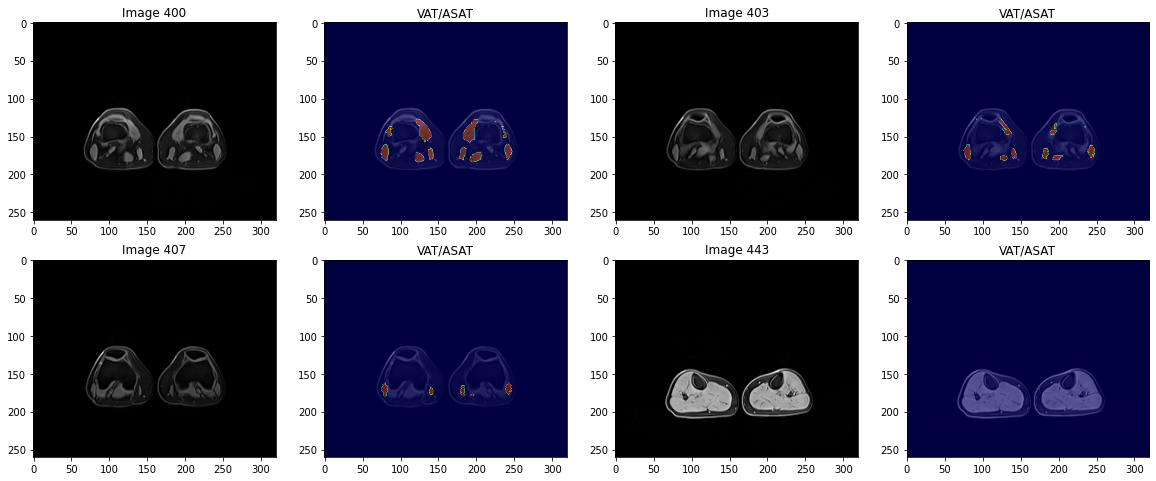

In [ ]:
slice_ = 400

plt.figure(figsize=(20,8))
plt.subplot(241)
plt.title('Image ' + str(slice_))
plt.imshow(origin_fat[slice_, :, :], cmap='gray')
plt.axis('on')
plt.subplot(242)
plt.title('VAT/ASAT')
plt.imshow(origin_fat[slice_, :, :], cmap='gray')
plt.imshow(origin_fat_label[slice_, :, :], cmap='jet', alpha = 0.5)
plt.axis('on')

plt.subplot(243)
plt.title('Image ' + str(slice_ + 3))
plt.imshow(origin_fat[slice_ + 3, :, :], cmap='gray')
plt.axis('on')
plt.subplot(244)
plt.title('VAT/ASAT')
plt.imshow(origin_fat[slice_ + 3, :, :], cmap='gray')
plt.imshow(origin_fat_label[slice_ + 3, :, :], cmap='jet', alpha = 0.5)

plt.subplot(245)
plt.title('Image ' + str(slice_ + 7))
plt.imshow(origin_fat[slice_ + 7, :, :], cmap='gray')
plt.axis('on')
plt.subplot(246)
plt.title('VAT/ASAT')
plt.imshow(origin_fat[slice_ + 7, :, :], cmap='gray')
plt.imshow(origin_fat_label[slice_ + 7, :, :], cmap='jet', alpha = 0.5)

plt.subplot(247)
plt.title('Image ' + str(slice_ + 43))
plt.imshow(origin_fat[slice_ + 43, :, :], cmap='gray')
plt.axis('on')
plt.subplot(248)
plt.title('VAT/ASAT')
plt.imshow(origin_fat[slice_ + 43, :, :], cmap='gray')
plt.imshow(origin_fat_label[slice_ + 43, :, :], cmap='jet', alpha = 0.5)

plt.show()